# Load Data

In [1]:
#This is the Kaggle challenge
#check current directory
%cd
#change working directory where the file is
%cd ~\Desktop\Book_ML_deepL

C:\Users\EAMC
C:\Users\EAMC\Desktop\Book_ML_deepL


In [2]:
##manual download, then use pd
import pandas as pd
import csv as csv

test_mnist= pd.read_csv('test_MNIST.csv', sep=',')
train_mnist = pd.read_csv('train_MNIST.csv', sep=',')

In [3]:
# ON MNIST kaggle data
X_train_MNIST, Y_train_MNIST= train_mnist.iloc[:, 1:], train_mnist.iloc[:, 0]

# Train model

In [5]:
from sklearn.ensemble import RandomForestClassifier
daje= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
daje.fit(X_train_MNIST, Y_train_MNIST)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [7]:
param_grid = {"n_estimators": [int(i) for i in range(1,30, 3)],
              "max_depth": [None],
              "max_features": [5, 10, 100],
              "min_samples_split": [3, 10],
              "criterion": ["gini", "entropy"]}

In [9]:
#randomized search on MNIST
from sklearn.model_selection import RandomizedSearchCV
rfclass = RandomForestClassifier(random_state=42)
rf_random_MNIST = RandomizedSearchCV(estimator = rfclass, param_distributions = param_grid, n_iter = 5, cv = 3, random_state=42)
rf_random_MNIST.fit(X_train_MNIST, Y_train_MNIST)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'n_estimators': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28], 'max_depth': [None], 'max_features': [5, 10, 100], 'min_samples_split': [3, 10], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [50]:
rf_random_MNIST.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 100,
 'min_samples_split': 3,
 'n_estimators': 22}

# Data Augmentation

In [17]:
from scipy.ndimage.interpolation import shift

In [18]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [38]:
#X_train_MNIST is now a dataframe, we need to convert it to a numpy ndarray
X_train_MNIST= X_train_MNIST.values 
type(X_train_MNIST)

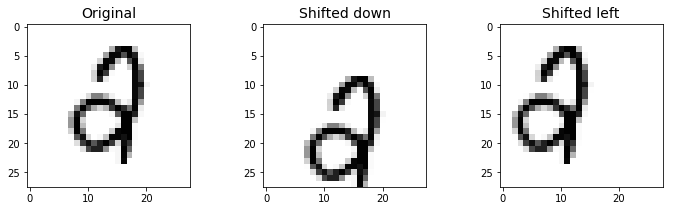

In [46]:
import matplotlib.pyplot as plt
import numpy as np

image = X_train_MNIST[10000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [47]:
X_train_augmented = [image for image in X_train_MNIST]
y_train_augmented = [label for label in Y_train_MNIST]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train_MNIST, Y_train_MNIST):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [48]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [52]:
# train again the random forest with the augmented data
rf_random_aug= RandomForestClassifier(**rf_random_MNIST.best_params_)
rf_random_aug.fit(X_train_augmented, y_train_augmented)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=22, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Submit

In [54]:
# prediction
rf_pred_MNIST = rf_random_aug.predict(test_mnist)
#convert to integer
rf_pred_MNIST = rf_pred_MNIST.astype(int)
#create a series with the predictions
results = pd.Series(rf_pred_MNIST,name="Label")
# then a second series with the index from 1 to x
index= pd.Series(range(1,28001), name = "ImageId")
#join the two series into a single dataframe
submission = pd.concat([index, results], axis = 1)
#save results to csv
submission.to_csv("rf_mnist.csv",index=False)